In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from PIL import Image

import re, string, unicodedata
# import spacy
import contractions
import warnings
import inflect
from textblob import TextBlob, Word

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
# from nltk.stem import LancasterStemmer, WordNetLemmatizer
# from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

import sys
sys.path.append('../../lib')

from helper_functions_2 import make_autopct, fast_mode , apply_labels 
from helper_functions_2 import MyTextTransformer, MyTextPlots

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

### load the data 

In [552]:
train = pd.read_csv("data/updated_train.csv")
test = pd.read_csv("data/updated_test.csv")

train.head()

,ID,text,target,wcount,tlength,word_len,polarity,subjectivity,clean
0,train_0,The bitcoin halving is cancelled due to,1,7,39,5.571429,-0.125000,0.375000,bitcoin halve cancel due
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,20,117,5.850000,0.700000,0.600000,mercyofallah good time wrap granular detail ch...
2,train_2,266 Days No Digital India No Murder of e learn...,1,20,93,4.650000,0.000000,0.000000,266 days digital india murder e learn 2g onlin...
3,train_3,India is likely to run out of the remaining RN...,1,23,112,4.869565,0.000000,0.650000,india likely run remain rna kit essential test...
4,train_4,In these tough times the best way to grow is t...,0,26,121,4.653846,0.305556,0.566667,tough time best way grow learn case teach help...


#### feature engineering for word count

In [554]:
class FeatureEngineering(BaseEstimator,TransformerMixin):
    def __init__(self, field):
        self.field = field
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["wcount"] = X[self.field].apply(lambda x: len(x.split()))
        X["tlength"] = X[self.field].apply(lambda x: len(x))
        X["word_len"] = X["tlength"]/X["wcount"]
        
        X["polarity"] = X[self.field].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        X["subjectivity"] = X[self.field].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
        
        return X
    
train = FeatureEngineering("text").fit_transform(train)
test = FeatureEngineering("text").fit_transform(test)

### Exploratory Data Analysis

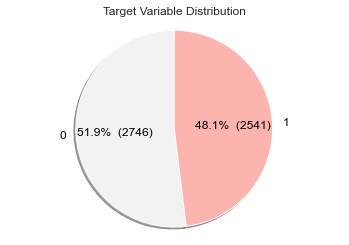

In [516]:
targets_dict = train["target"].value_counts()
cmap = plt.get_cmap('Pastel1_r')
c = [cmap(i) for i in np.linspace(0, 1, len(targets_dict.index))]
plt.pie(targets_dict.values, labels= targets_dict.index, colors= c,
        shadow= True, autopct=make_autopct(targets_dict.values, is_perc='both'),
        startangle = 90, textprops = {'color': 'black', 'fontsize': 12})
plt.axis('equal')
plt.title("Target Variable Distribution")
plt.show()

- data is nicely balanced so we may not have to worry about class imbalance in this dataset

#### investigate the average word length 

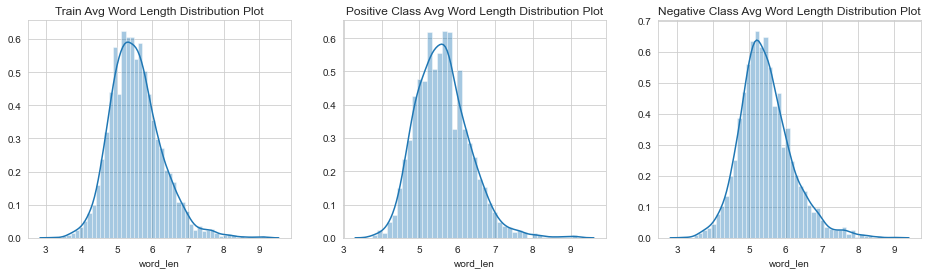

In [517]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)

sns.distplot(train.word_len)
plt.title("Train Avg Word Length Distribution Plot")

plt.subplot(1,3,2)
sns.distplot(train[train.target ==1].word_len)
plt.title("Positive Class Avg Word Length Distribution Plot")

plt.subplot(1,3,3)
sns.distplot(train[train.target ==0].word_len)
plt.title("Negative Class Avg Word Length Distribution Plot")
plt.show()

In [518]:
train[["wcount", "tlength"]].corr()

,wcount,tlength
wcount,1.000000,0.969846
tlength,0.969846,1.000000


- there is a mean difference in the number of words between the classes
- we can use this to help our model better classify them.
- but given the correlation matrix above we have to pick one of them.

#### investigate variations in the tweet word count and tweet character length

In [519]:
train.groupby("target")[["wcount", "tlength"]].describe()#.T #[["mean", "std"]]

wcount                                                    tlength  \
         count       mean        std  min   25%   50%   75%   max   count   
target                                                                      
0       2746.0  20.815732  11.138812  3.0  13.0  20.0  24.0  61.0  2746.0   
1       2541.0  19.655647   8.577660  3.0  15.0  19.0  22.0  55.0  2541.0   

                                                                
              mean        std   min   25%    50%    75%    max  
target                                                          
0       112.019665  58.483977  21.0  70.0  108.0  128.0  302.0  
1       108.739079  45.731715  19.0  83.0  108.0  119.0  278.0

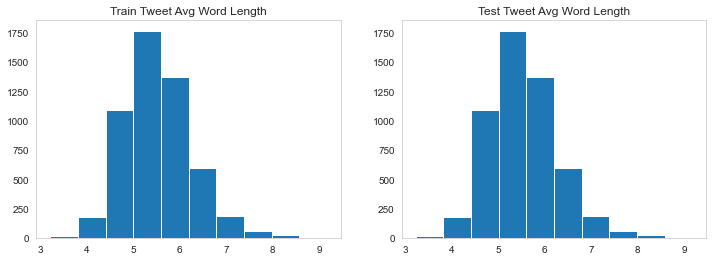

In [520]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
train["word_len"].hist(grid=False)
plt.title("Train Tweet Avg Word Length")
plt.subplot(1,2,2)
test["word_len"].hist(grid=False)
plt.title("Test Tweet Avg Word Length")
plt.show()

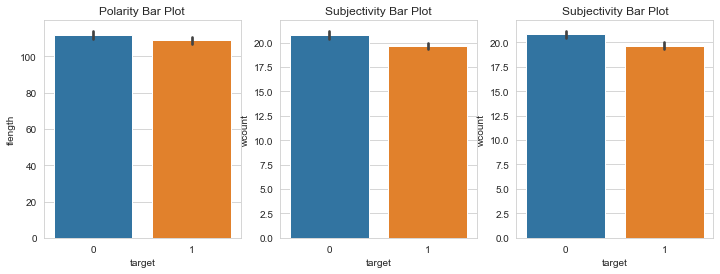

In [521]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
sns.barplot(x="target", y="tlength", data=train)
plt.title("Polarity Bar Plot")
plt.subplot(1,3,2)
sns.barplot(x="target", y="wcount", data=train)
plt.title("Subjectivity Bar Plot")

plt.subplot(1,3,3)
sns.barplot(x="target", y="wcount", data=train)
plt.title("Subjectivity Bar Plot")
plt.show()

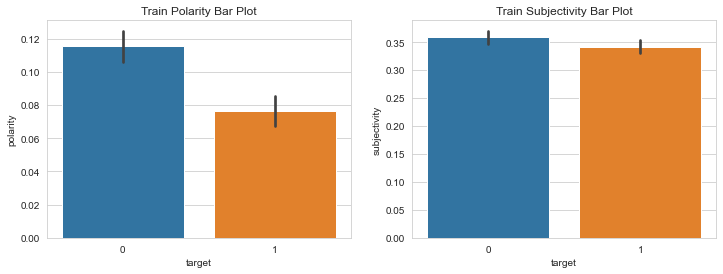

In [522]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.barplot(x="target", y="polarity", data=train)
plt.title("Train Polarity Bar Plot")
plt.subplot(1,2,2)
sns.barplot(x="target", y="subjectivity", data=train)
plt.title("Train Subjectivity Bar Plot")
plt.show()

- There is a clear divide between the positive and negative class when it comes to the sentiment as seen on the polarity plot.
- The positive class has significantly less positive sentiment compared to the negative class. We can use this as a feature.
- Generally the postive class seems to contain less personal opinion compared to the negative class as seen by the subjectivity plot.

#### process the text data ready for modeling

In [558]:
train["clean"] = train["text"].apply(MyTextTransformer().transform, skip_steps=['inflect'])
test["clean"] = test["text"].apply(MyTextTransformer().transform, skip_steps=['inflect'])

#### common words among the negative class

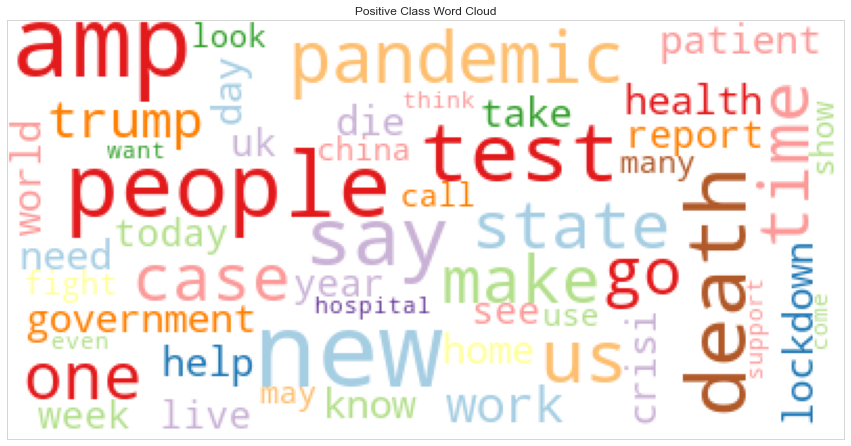

In [533]:
pos_class = train[train["target"] == 1]['clean'].str.cat(sep = ",")
pos_word = (MyTextPlots().plot_word_cloud(pos_class, title='Positive Class Word Cloud', 
                                                 max_words=50, cmap='Paired', 
                                                 figsize=(15, 12), savefig=True)
           )

#### common words among the negative class

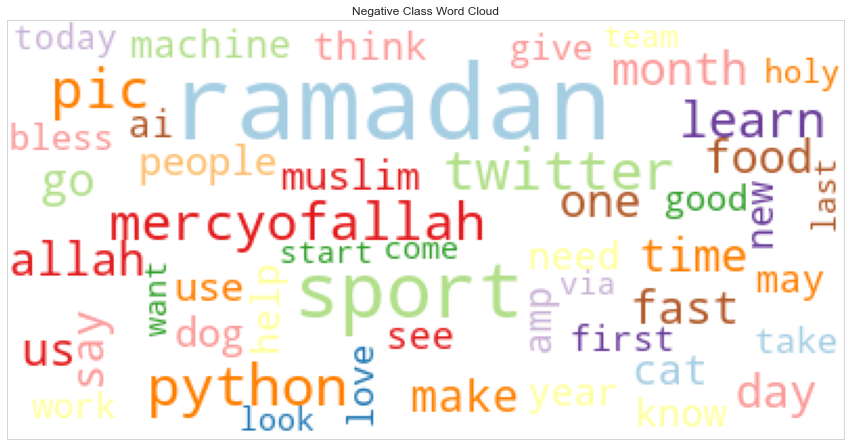

In [534]:
neg_class = train[train["target"] == 0]['clean'].str.cat(sep = ",")
neg_word = (MyTextPlots().plot_word_cloud(neg_class, title='Negative Class Word Cloud', 
                                                 max_words=50, cmap='Paired', 
                                                 figsize=(15, 12), savefig=True)
           )

In [526]:
# blob_obj = TextBlob(train["text"][0])

# def text_blob_processor(x):
#     try:
#     #     blob_obj.translate(to="en")
#     #     res = blob_obj.correct()
#     #     res = blob_obj.lower()
#     #     res = blob_obj.word_counts()
#     #     res = blob_obj.words.singularize()
#     #     res = [Word(i).lemmatize("n") for i in blob_obj.words.singularize()]
# #         lemmatized = [word.lemmatize("v") for word in TextBlob(str(x)).lower().correct().words]
#         lemmatized = [word for word in TextBlob(str(x)).lower().correct().words]
# #         no_stopwords = [word for word in lemmatized if word not in stopwords.words('english')]
#         return " ".join(lemmatized)
#     except NotTranslated as e:
#         print(blob)
#     except Exception as e:
#         print(e)
    
# process = train.loc[:1000, "text"].apply(text_blob_processor)

In [527]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# train["text"].apply(lambda x: 1 if())

### machine learning

In [528]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.base import TransformerMixin, BaseEstimator

#### initial train test split with only text field

In [535]:
X = train["clean"]
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27)

#### initial model fit with no param tuning

In [536]:
vect = TfidfVectorizer(ngram_range=(1,2))

pipe = Pipeline([
    ('vect',TfidfVectorizer(ngram_range=(1,2)) ),
    ('svd', TruncatedSVD(algorithm='randomized', n_components=350)),
    ('model', XGBClassifier(n_estimators=500, learning_rate= 0.05, random_state = 27)),
])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
roc_auc = metrics.roc_auc_score(y_test, preds)
print(f"best score from random search: {roc_auc}")

best score from random search: 0.8808895090883069


#### cross validation score test to see how our model performs

In [537]:
cv = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv = 3)
print(f"mean cross_val_score: {np.mean(cv)}")
print(f"the individual scores are: {cv}")

mean cross_val_score: 0.939280843986181
the individual scores are: [0.94454509 0.93755756 0.93573988]


#### parameter tuning using RandomizedSearchCV

In [538]:
param_grid = {
    'vect__ngram_range': [(1,2), (1,3)],
    'svd__n_components': [150, 250, 350],
    'model__n_estimators' :[250, 350,500],
    'model__learning_rate' :[0.01, 0.05, 0.1],
    'model__subsample':[0.3, 0.6, 0.9],
}

rcv = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3, scoring="roc_auc", random_state=27)
rcv.fit(X_train, y_train)
print(f"best score from random search: {rcv.best_score_}")
print("best paramaters".center(40))
print(rcv.best_params_)

best score from random search: 0.9439943484321845
            best paramaters             
{'vect__ngram_range': (1, 2), 'svd__n_components': 250, 'model__subsample': 0.9, 'model__n_estimators': 500, 'model__learning_rate': 0.1}


In [539]:
roc_auc = metrics.roc_auc_score(y_test, rcv.best_estimator_.predict(X_test))
confusion = metrics.confusion_matrix(y_test, rcv.best_estimator_.predict(X_test))

print(f"roc_auc_score : {roc_auc}")
print()
print(f"confusion matrix".center(40, " "))
print(confusion)

roc_auc_score : 0.877676399026764

            confusion matrix            
[[487  61]
 [ 68 442]]


#### make submission file

In [559]:
# pipe = Pipeline([
#     ('vect',TfidfVectorizer(ngram_range=(1,2)) ),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300, random_state=27)),
#     ('model', XGBClassifier(n_estimators=500, subsample=0.9, learning_rate=0.1, random_state=27)),
# ])

# pipe.fit(X, y)
preds_proba = rcv.best_estimator_.predict_proba(test["clean"])[:,1]
submission = test.iloc[:, 0].to_frame()
submission["target"] = preds_proba.tolist()
submission.head()

,ID,target
0,test_2,0.318525
1,test_3,0.000133
2,test_4,0.000467
3,test_8,0.994453
4,test_9,0.001815


In [561]:
submission.to_csv("submissions/third_xgb.csv", index=None)

### Adding More Features

In [562]:
class TextSelector(TransformerMixin, BaseEstimator):
    def __init__(self, field):
        self.field = field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.field]


class NumberSelector(TransformerMixin, BaseEstimator):
    def __init__(self, field):
        self.field = field
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.loc[:, self.field]


class ReshapeData(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if X.shape[1] == 1:
            return X.reshape(-1,1)
        return X

#### generate new train_test_split with the extra column(s)

In [391]:
X = train.loc[:, ["clean", "word_len", "polarity"]]
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27)

In [392]:
pipe = Pipeline([
    ('features', FeatureUnion([
        # process the text column
        ('text', Pipeline([
            ('text_col', TextSelector('clean')),
            ('vect', TfidfVectorizer(ngram_range=(1,2), max_df=0.5)),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300, random_state=27)),
        ])
        ),
     # process the numerical features
       ('digits', Pipeline([
            ('num_col', NumberSelector(["word_len"])),
            ('scaler', MinMaxScaler()), #StandardScaler()), # FunctionTransformer(np.log1p)),
            ('reshape', ReshapeData())
        ])
        ),
       ('polarity', Pipeline([
            ('num_col', NumberSelector(["polarity"])),
        ])
        ),
    ])
    ),
    ('model', XGBClassifier(n_estimators=500, subsample=0.8, learning_rate=0.1, random_state=27)),
])


pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
roc_auc = metrics.roc_auc_score(y_test, preds)
confusion = metrics.confusion_matrix(y_test, preds)

print(f"roc_auc_score : {roc_auc}")
print()
print(f"confusion matrix".center(40, " "))
print(confusion)

roc_auc_score : 0.8913339058251037

            confusion matrix            
[[488  60]
 [ 55 455]]


In [512]:
# invest = X_test.iloc[:, :]
# invest["y_test"] = y_test
# invest["preds"] = preds

# invest[invest["y_test"] < invest["preds"]] #["clean"].tolist()

In [219]:
cv = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv = 5)
print(f"mean cross_val_score: {np.mean(cv)}")
print(f"the individual scores are: {cv}")

mean cross_val_score: 0.9468276184944873
the individual scores are: [0.95040764 0.94565047 0.93510412 0.94933066 0.95364521]


In [256]:
param_grid = {
    'features__text__vect__ngram_range': [(1,2), (1,3)],
    'features__text__vect__max_df': [0.25, 0.5, 0.75],
    'features__text__svd__n_components': [150, 250, 350],
    'model__n_estimators' :[350,500,750],
    'model__learning_rate' :[0.3, 0.6, 0.9],
    'model__subsample':[0.4, 0.8, 1],
}

rcv = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=5, scoring="roc_auc", random_state=27)
rcv.fit(X_train, y_train)

print(f"best score from random search: {rcv.best_score_}")
print()
print(f"best paramters".center(40, ""))
print(rcv.best_params_)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('features',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('text',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('text_col',
                                                                                               TextSelector(field='clean')),
                                                                                              ('vect',
                                                                                               TfidfVectorizer(analyzer='word',
                                                                                                               b

In [260]:
metrics.roc_auc_score(y_test, rcv.best_estimator_.predict(X_test))
metrics.confusion_matrix(y_test, rcv.best_estimator_.predict(X_test))

0.8931587233433519

In [271]:
pipe = Pipeline([
    ('features', FeatureUnion([
        # process the text column
        ('text', Pipeline([
            ('text_col', TextSelector('clean')),
            ('vect', TfidfVectorizer(ngram_range=(1,2), max_df=0.5)),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300, random_state=27)),
        ])
        ),
     # process the numerical features
       ('digits', Pipeline([
            ('num_col', NumberSelector(["tlength"])),
            ('scaler', StandardScaler()), #MinMaxScaler()),  FunctionTransformer(np.log1p)),
            ('reshape', ReshapeData())
        ])
        ),
       ('polarity', Pipeline([
            ('pol_col', NumberSelector(["polarity"])),
        ])
        ),
    ])
    ),
    ('model', XGBClassifier(n_estimators=500, subsample=1, learning_rate=0.1, random_state=27)),
])

pipe.fit(X, y)
preds_proba = pipe.predict_proba(test[["clean","tlength","polarity"]])[:,1]
submission = test.iloc[:, 0].to_frame()
submission["target"] = preds_proba.tolist()
submission.head()

,ID,target
0,test_2,0.31
1,test_3,0.00
2,test_4,0.01
3,test_8,0.84
4,test_9,0.00


In [285]:
# submission.to_csv("submissions/forth_fe.csv", index=None)